In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

# Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

### Functions to optimize

In [4]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

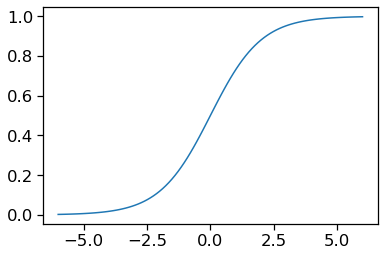

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

### Data set for classification

In [6]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

### Using gradient descent for classification by logistic regression

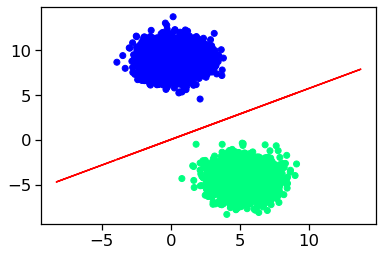

In [7]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [8]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [9]:
def logistic2(x):
    """Logistic function."""
    return 1/(1 + np.exp(-x))

In [10]:
%timeit logistic(x)

239 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit logistic2(x)

181 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [12]:
@vectorize([float64(float64)], target='cpu')
def logistic_numba_cpu(x):
    """Logistic function."""
    return 1/(1 + math.exp(-x))

In [13]:
@vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    """Logistic function."""
    return 1/(1 + math.exp(-x))

In [14]:
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_cpu(x))
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_parallel(x))

In [17]:
%timeit logistic(x)

239 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit logistic_numba_cpu(x)

109 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit logistic_numba_parallel(x)

18.9 ms ± 747 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
@jit(float64[:](float64[:]), nopython=True)
def logistic_numba(x):
    return 1/(1 + np.exp(-x))

In [9]:
@jit(float64[:](float64[:,:], float64[:], float64[:], float64, int64), nopython=True)
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

C:\Users\petri\AppData\Local\Temp/ipykernel_13916/250247575.py:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  y_pred = logistic_numba(X @ beta)
C:\Users\petri\AppData\Local\Temp/ipykernel_13916/250247575.py:9: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  grad = Xt @ epsilon / n
C:\Users\petri\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
C:\Users\petri\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


In [10]:
beta1 = gd(X, y, β, α, niter)
beta2 = gd_numba(X, y, β, α, niter)
np.testing.assert_almost_equal(beta1, beta2)

In [11]:
%timeit gd(X, y, β, α, niter)

307 ms ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit gd_numba(X, y, β, α, niter)

311 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


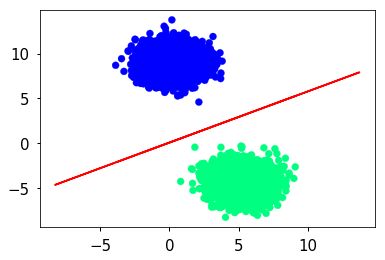

In [25]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd_numba(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [26]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def logistic_cython(double[:] x):
    """Logistic function."""
    cdef int i
    cdef int n = x.shape[0]
    cdef double [:] s = np.empty(n)
    
    for i in range(n):
        s[i] = 1.0/(1.0 + exp(-x[i]))
    return s

In [27]:
np.testing.assert_array_almost_equal(logistic(x), logistic_cython(x))

In [28]:
%timeit logistic2(x)

182 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit logistic_cython(x)

111 ms ± 887 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef double[:] logistic_(double[:] x):
    """Logistic function."""
    cdef int i
    cdef int n = x.shape[0]
    cdef double [:] s = np.empty(n)
    
    for i in range(n):
        s[i] = 1.0/(1.0 + exp(-x[i]))
    return s

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def gd_cython(double[:, ::1] X, double[:] y, double[:] beta, double alpha, int niter):
    """Gradient descent algorihtm."""    
    cdef int n = X.shape[0]
    cdef int p = X.shape[1]
    cdef double[:] eps = np.empty(n)
    cdef double[:] y_pred = np.empty(n)
    cdef double[:] grad = np.empty(p)  
    cdef int i, j, k
    cdef double[:, :] Xt = X.T
    
    for i in range(niter):
        y_pred = logistic_(np.dot(X, beta))
        for j in range(n):
            eps[j] = y[j] - y_pred[j]
        grad = np.dot(Xt, eps) / n
        for k in range(p):
            beta[k] += alpha * grad[k]
    return beta

In [32]:
niter = 1000
alpha = 0.01
beta = np.random.random(X.shape[1])

In [33]:
beta1 = gd(X, y, β, α, niter)
beta2 = gd_cython(X, y, β, α, niter)
np.testing.assert_almost_equal(beta1, beta2)

In [34]:
%timeit gd(X, y, beta, alpha, niter)

385 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit gd_cython(X, y, beta, alpha, niter)

278 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [40]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>

namespace py = pybind11;

Eigen::VectorXd logistic(Eigen::VectorXd x) {
    return 1.0/(1.0 + exp((-x).array()));
}

Eigen::VectorXd gd(Eigen::MatrixXd X, Eigen::VectorXd y, Eigen::VectorXd beta, double alpha, int niter) {
    int n = X.rows();
    
    Eigen::VectorXd y_pred;
    Eigen::VectorXd resid;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();
            
    for (int i=0; i<niter; i++) {
        y_pred = logistic(X * beta);
        resid = y - y_pred;
        grad = Xt * resid / n;
        beta = beta + alpha * grad;
    }
    return beta;
}

PYBIND11_MODULE(wrap, m) {
    m.doc() = "pybind11 example plugin";
    m.def("gd", &gd, "The gradient descent fucntion.");
    m.def("logistic", &logistic, "The logistic fucntion.");
}

Overwriting wrap.cpp


In [41]:
import cppimport
cppimport.force_rebuild() 
funcs = cppimport.imp("wrap")

In [42]:
np.testing.assert_array_almost_equal(logistic(x), funcs.logistic(x))

In [43]:
%timeit logistic(x)

239 ms ± 755 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%timeit funcs.logistic(x)

113 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
β = np.array([0.0, 0.0, 0.0])
gd(X, y, β, α, niter)

array([ 0.04482678,  0.45549046, -0.79878438])

In [46]:
β = np.array([0.0, 0.0, 0.0])
funcs.gd(X, y, β, α, niter)

array([ 0.04482678,  0.45549046, -0.79878438])

In [47]:
%timeit gd(X, y, β, α, niter)

388 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%timeit funcs.gd(X, y, β, α, niter)

122 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


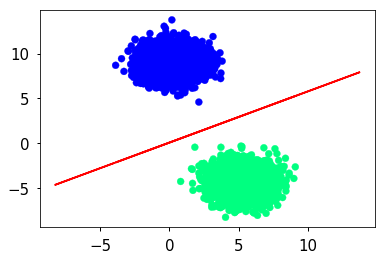

In [49]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = funcs.gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = funcs.logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass